In [4]:
# import modules
import os
import anndata as ad
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp
from gseapy.plot import gseaplot
import seaborn as sns
import matplotlib.pyplot as plt
import re
from statannot import add_stat_annotation


sns.set(font='Arial')

In [5]:
# set working directory
os.chdir('/Volumes/Passport/CSDB/brain_scRNAseq/all_internship/')

In [6]:
# load in data
adata = sc.read_h5ad('data/processed/annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 37581 × 4000
    obs: 'Sample', 'condition', 'filtered', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'cell_type', 'condition_density'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'condition_density_params', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_expr'
    obsp: 'connectivities', 'distances'

In [127]:
# load in metadata, including enrichment scores
meta = pd.read_csv('data/processed/metadata_ES.csv', index_col=0)
meta

,LINEs,LTRs,SenMayo,senescent_top10_perc
old_AAACCTGGTTCTCATT.1,0.357415,0.270314,0.103331,senescent
old_AAACCTGTCGGTTCGG.1,0.284554,0.265461,0.091186,other
old_AAACGGGAGCGATGAC.1,0.312759,0.259830,0.094836,other
old_AAACGGGTCAAGGCTT.1,0.354488,0.283529,0.072223,other
old_AAACGGGTCCGTAGTA.1,0.312971,0.261709,0.060065,other
...,...,...,...,...
young_TTTGTCACATCACGAT.1,0.401377,0.287468,0.060085,other
young_TTTGTCAGTAAGGATT.1,0.358978,0.281024,0.064172,other
young_TTTGTCATCAGATAAG.1,0.333656,0.270040,0.102325,senescent
young_TTTGTCATCCAAACTG.1,0.320974,0.258299,0.070602,other


In [128]:
# extract info from metadata
LINEs = meta['LINEs'].tolist()
LTRs = meta['LTRs'].tolist()
SenMayo = meta['SenMayo'].tolist()
top10 = meta['senescent_top10_perc']

In [129]:
# add metadata to scanpy object
adata.obs['LINEs'] = LINEs
adata.obs['LTRs'] = LTRs
adata.obs['SenMayo'] = SenMayo
adata.obs['sen_top10_perc'] = top10
adata.obs

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc
old_AAACCTGGTTCTCATT.1,OX1X,old,True,3784.0,1569,1569,3784.0,194.0,5.126850,0,0,10,arachnoid barrier & choroid plexus cells,0.076720,0.357415,0.270314,0.103331,senescent
old_AAACCTGTCGGTTCGG.1,OX1X,old,True,3280.0,1120,1120,3280.0,98.0,2.987805,0,0,9,"monocytes, neutrophils & dendritic cells",0.035155,0.284554,0.265461,0.091186,other
old_AAACGGGAGCGATGAC.1,OX1X,old,True,5115.0,2015,2015,5115.0,219.0,4.281525,0,0,4,endothelial & vascular cells,0.229350,0.312759,0.259830,0.094836,other
old_AAACGGGTCAAGGCTT.1,OX1X,old,True,2711.0,1375,1375,2711.0,399.0,14.717815,0,0,5,astrocytes,0.291825,0.354488,0.283529,0.072223,other
old_AAACGGGTCCGTAGTA.1,OX1X,old,True,3738.0,1665,1665,3738.0,203.0,5.430711,0,0,0,oligodendrocytes,0.879616,0.312971,0.261709,0.060065,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young_TTTGTCACATCACGAT.1,YX8L,young,True,4290.0,1987,1987,4290.0,439.0,10.233101,0,0,1,astrocytes,0.656280,0.401377,0.287468,0.060085,other
young_TTTGTCAGTAAGGATT.1,YX8L,young,True,8442.0,2724,2724,8442.0,502.0,5.946458,0,0,0,oligodendrocytes,0.243005,0.358978,0.281024,0.064172,other
young_TTTGTCATCAGATAAG.1,YX8L,young,True,2526.0,1253,1253,2526.0,204.0,8.076009,0,0,3,microglia & macrophages,0.393192,0.333656,0.270040,0.102325,senescent
young_TTTGTCATCCAAACTG.1,YX8L,young,True,4251.0,1805,1805,4251.0,264.0,6.210303,0,0,0,oligodendrocytes,0.684638,0.320974,0.258299,0.070602,other


In [131]:
# make a new column that has a value of 1 when a cell is senescent
adata.obs['sen_counter'] = 0
adata.obs.loc[adata.obs['sen_top10_perc'] == 'senescent', 'sen_counter'] = 1
adata.obs

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter
old_AAACCTGGTTCTCATT.1,OX1X,old,True,3784.0,1569,1569,3784.0,194.0,5.126850,0,0,10,arachnoid barrier & choroid plexus cells,0.076720,0.357415,0.270314,0.103331,senescent,1
old_AAACCTGTCGGTTCGG.1,OX1X,old,True,3280.0,1120,1120,3280.0,98.0,2.987805,0,0,9,"monocytes, neutrophils & dendritic cells",0.035155,0.284554,0.265461,0.091186,other,0
old_AAACGGGAGCGATGAC.1,OX1X,old,True,5115.0,2015,2015,5115.0,219.0,4.281525,0,0,4,endothelial & vascular cells,0.229350,0.312759,0.259830,0.094836,other,0
old_AAACGGGTCAAGGCTT.1,OX1X,old,True,2711.0,1375,1375,2711.0,399.0,14.717815,0,0,5,astrocytes,0.291825,0.354488,0.283529,0.072223,other,0
old_AAACGGGTCCGTAGTA.1,OX1X,old,True,3738.0,1665,1665,3738.0,203.0,5.430711,0,0,0,oligodendrocytes,0.879616,0.312971,0.261709,0.060065,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young_TTTGTCACATCACGAT.1,YX8L,young,True,4290.0,1987,1987,4290.0,439.0,10.233101,0,0,1,astrocytes,0.656280,0.401377,0.287468,0.060085,other,0
young_TTTGTCAGTAAGGATT.1,YX8L,young,True,8442.0,2724,2724,8442.0,502.0,5.946458,0,0,0,oligodendrocytes,0.243005,0.358978,0.281024,0.064172,other,0
young_TTTGTCATCAGATAAG.1,YX8L,young,True,2526.0,1253,1253,2526.0,204.0,8.076009,0,0,3,microglia & macrophages,0.393192,0.333656,0.270040,0.102325,senescent,1
young_TTTGTCATCCAAACTG.1,YX8L,young,True,4251.0,1805,1805,4251.0,264.0,6.210303,0,0,0,oligodendrocytes,0.684638,0.320974,0.258299,0.070602,other,0


In [132]:
# caclulate the count of senescent cells for eachs ample
sample_counts = adata.obs.groupby('Sample')['sen_counter'].sum()
df_sample_counts = pd.DataFrame(sample_counts)
df_sample_counts

,sen_counter
Sample,
OX1X,211
OX2X,149
OX3X,422
OX4X,495
OX5X,235
OX6X,246
OX7X,218
OX8X,283
YX1L,130


In [133]:
# add a 'condition' column
conditions = ['old'] * 8 + ['young'] * 8
df_sample_counts['condition'] = conditions
df_sample_counts

,sen_counter,condition
Sample,,
OX1X,211,old
OX2X,149,old
OX3X,422,old
OX4X,495,old
OX5X,235,old
OX6X,246,old
OX7X,218,old
OX8X,283,old
YX1L,130,young


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

young v.s. old: t-test independent samples with Bonferroni correction, P_val=5.567e-02 stat=-2.087e+00


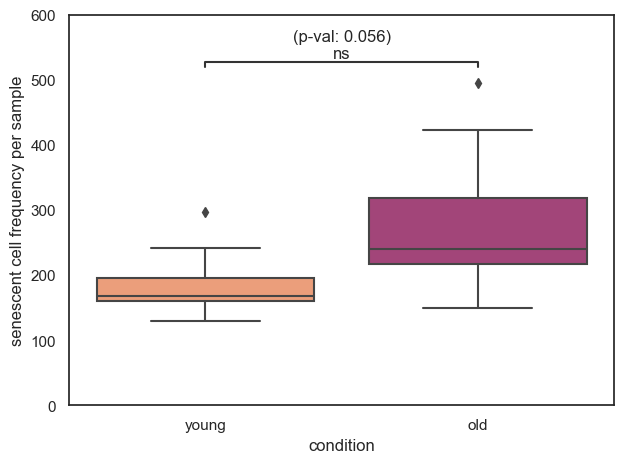

In [186]:
# plot the number of marked senescent cells for each condition

sns.set_style("white")

# Filter the DataFrame for 'old' and 'young' conditions
df_old = df_sample_counts[df_sample_counts['condition'] == 'old']
df_young = df_sample_counts[df_sample_counts['condition'] == 'young']

# Combine 'old' and 'young' DataFrames
combined_df = pd.concat([df_young, df_old])

# Create the violin plot using seaborn
ax = sns.boxplot(data=combined_df, x='condition', y='sen_counter', palette={'young':plt.cm.magma(200), 'old':plt.cm.magma(125)})

# Add statistical significance annotation
add_stat_annotation(ax, data=combined_df,
                    x='condition',
                    y='sen_counter',
                    test='t-test_ind',
                    comparisons_correction='bonferroni',
                    box_pairs=[('old', 'young')])

# Set the x-axis label
plt.xlabel('condition')

# Set the y-axis label
plt.ylabel('senescent cell frequency per sample')
ax.text(0.32, 560, '(p-val: 0.056)', fontsize=12, fontname = 'Arial')

# Set the y-axis limits
plt.ylim(0, 600)

plt.tight_layout()
plt.savefig('figures/report/UCell/top10_boxplot.png', dpi = 300)
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

young v.s. old: t-test independent samples with Bonferroni correction, P_val=9.070e-111 stat=-2.244e+01


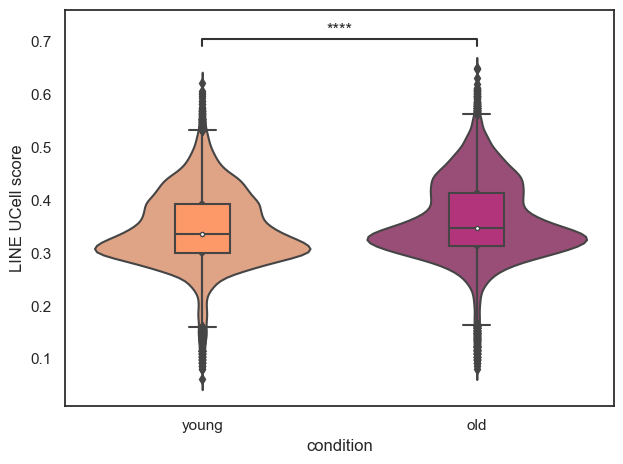

In [148]:
# plot the distribution of UCell scores for LINEs

df_old = adata.obs[adata.obs['condition'] == 'old']
df_young = adata.obs[adata.obs['condition'] == 'young']

# Combine 'old' and 'young' DataFrames
combined_df = pd.concat([df_young, df_old])
combined_df['condition'] = pd.Categorical(combined_df['condition'], categories=['young', 'old'])

# Create the violin plot using seaborn
ax = sns.violinplot(data=combined_df, x='condition', y='LINEs', palette={'young':plt.cm.magma(200), 'old':plt.cm.magma(125)}, saturation = 0.6)

sns.boxplot(x='condition', y='LINEs', data=combined_df, palette={'young':plt.cm.magma(200), 'old':plt.cm.magma(125)}, saturation = 1, width=0.2,
            boxprops={'zorder': 2}, ax=ax)

# Add statistical significance annotation
add_stat_annotation(ax, data=combined_df,
                    x='condition',
                    y='LINEs',
                    test='t-test_ind',
                    comparisons_correction='bonferroni',
                    box_pairs=[('old', 'young')])

# Set the x-axis label
plt.xlabel('condition')

# Set the y-axis label
plt.ylabel('LINE UCell score')

plt.tight_layout()

# save figure
plt.savefig('figures/report/UCell/violin_LINE_UCell.png', dpi = 300)
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

young v.s. old: t-test independent samples with Bonferroni correction, P_val=2.557e-130 stat=-2.438e+01


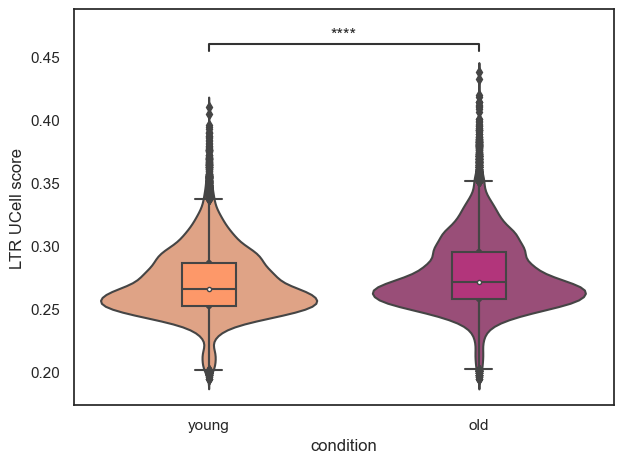

In [149]:
# plot the distribution of UCell scores for LTRs

# Filter the DataFrame for 'old' and 'young' conditions
df_old = adata.obs[adata.obs['condition'] == 'old']
df_young = adata.obs[adata.obs['condition'] == 'young']

# Combine 'old' and 'young' DataFrames
combined_df = pd.concat([df_young, df_old])
combined_df['condition'] = pd.Categorical(combined_df['condition'], categories=['young', 'old'])

# Create the violin plot using seaborn with larger boxplots
ax = sns.violinplot(data=combined_df, x='condition', y='LTRs', palette={'young':plt.cm.magma(200), 'old':plt.cm.magma(125)}, saturation = 0.6)

sns.boxplot(x='condition', y='LTRs', data=combined_df, palette={'young':plt.cm.magma(200), 'old':plt.cm.magma(125)}, saturation = 1, width=0.2,
            boxprops={'zorder': 2}, ax=ax)

# Add statistical significance annotation
add_stat_annotation(ax, data=combined_df,
                    x='condition',
                    y='LTRs',
                    test='t-test_ind',
                    comparisons_correction='bonferroni',
                    box_pairs=[('young', 'old')])

# Set the x-axis label
plt.xlabel('condition')

# Set the y-axis label
plt.ylabel('LTR UCell score')

# Save the figure
plt.tight_layout()
plt.savefig('figures/report/UCell/violin_LTR_UCell.png', dpi=300)

# Show the plot
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

young v.s. old: t-test independent samples with Bonferroni correction, P_val=9.149e-02 stat=1.688e+00


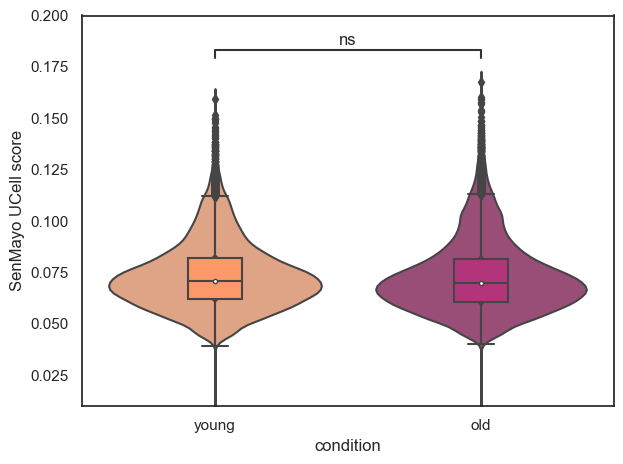

In [157]:
# plot the distribution of UCell scores for SenMayo

df_old = adata.obs[adata.obs['condition'] == 'old']
df_young = adata.obs[adata.obs['condition'] == 'young']

# Combine 'old' and 'young' DataFrames
combined_df = pd.concat([df_young, df_old])
combined_df['condition'] = pd.Categorical(combined_df['condition'], categories=['young', 'old'])

# Create the violin plot using seaborn
ax = sns.violinplot(data=combined_df, x='condition', y='SenMayo', palette={'young':plt.cm.magma(200), 'old':plt.cm.magma(125)}, saturation = 0.6)

sns.boxplot(x='condition', y='SenMayo', data=combined_df, palette={'young':plt.cm.magma(200), 'old':plt.cm.magma(125)}, saturation = 1, width=0.2,
            boxprops={'zorder': 2}, ax=ax)

# Add statistical significance annotation
add_stat_annotation(ax, data=combined_df,
                    x='condition',
                    y='SenMayo',
                    test='t-test_ind',
                    comparisons_correction='bonferroni',
                    box_pairs=[('young', 'old')])

#ax.axhline(y=0.09818362, linestyle='dotted', color='grey', )

# Set the x-axis label
plt.xlabel('condition')

# Set the y-axis label
plt.ylabel('SenMayo UCell score')

# Set the y-axis limits
plt.ylim(0.01, 0.200)

# Save the figure
plt.tight_layout()
plt.savefig('figures/report/UCell/violin_SenMayo_UCell_noline.png', dpi=300)

# Show the plot
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

young v.s. old: t-test independent samples with Bonferroni correction, P_val=9.149e-02 stat=1.688e+00


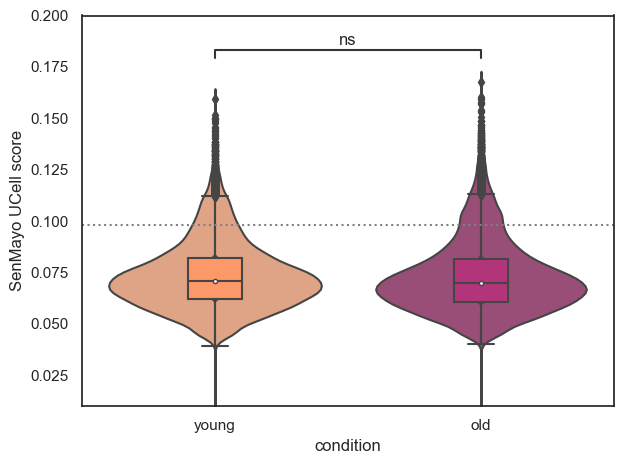

In [158]:
# plot the distribution of UCell scores for SenMayo (this time with line for threshold of top 10%)

df_old = adata.obs[adata.obs['condition'] == 'old']
df_young = adata.obs[adata.obs['condition'] == 'young']

# Combine 'old' and 'young' DataFrames
combined_df = pd.concat([df_young, df_old])
combined_df['condition'] = pd.Categorical(combined_df['condition'], categories=['young', 'old'])

# Create the violin plot using seaborn
ax = sns.violinplot(data=combined_df, x='condition', y='SenMayo', palette={'young':plt.cm.magma(200), 'old':plt.cm.magma(125)}, saturation = 0.6)

sns.boxplot(x='condition', y='SenMayo', data=combined_df, palette={'young':plt.cm.magma(200), 'old':plt.cm.magma(125)}, saturation = 1, width=0.2,
            boxprops={'zorder': 2}, ax=ax)

# Add statistical significance annotation
add_stat_annotation(ax, data=combined_df,
                    x='condition',
                    y='SenMayo',
                    test='t-test_ind',
                    comparisons_correction='bonferroni',
                    box_pairs=[('young', 'old')])

ax.axhline(y=0.09818362, linestyle='dotted', color='grey', )

# Set the x-axis label
plt.xlabel('condition')

# Set the y-axis label
plt.ylabel('SenMayo UCell score')

# Set the y-axis limits
plt.ylim(0.01, 0.200)

# Save the figure
plt.tight_layout()
plt.savefig('figures/report/UCell/violin_SenMayo_UCell_line.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
meta.to_csv('data/processed/metadata_for_correlation.csv')

In [7]:
# load in metadata
meta_data = pd.read_csv('data/processed/metadata_ES.csv', index_col='X')
meta_data = meta_data.drop(meta_data.columns[0], axis=1)
meta_data

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,X_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc
X,,,,,,,,,,,,,,,,,,,,
old_AAACCTGGTTCTCATT.1,OX1X,old,True,3784,1569,1569,3784,194,5.126850,0,0,10,arachnoid barrier & choroid plexus cells,0.076720,0.357415,0.270314,0.103331,senescent,1,senescent
old_AAACCTGTCGGTTCGG.1,OX1X,old,True,3280,1120,1120,3280,98,2.987805,0,0,9,"monocytes, neutrophils & dendritic cells",0.035155,0.284554,0.265461,0.091186,other,0,other
old_AAACGGGAGCGATGAC.1,OX1X,old,True,5115,2015,2015,5115,219,4.281525,0,0,4,endothelial & vascular cells,0.229350,0.312759,0.259830,0.094836,other,0,other
old_AAACGGGTCAAGGCTT.1,OX1X,old,True,2711,1375,1375,2711,399,14.717815,0,0,5,astrocytes,0.291825,0.354488,0.283529,0.072223,other,0,other
old_AAACGGGTCCGTAGTA.1,OX1X,old,True,3738,1665,1665,3738,203,5.430711,0,0,0,oligodendrocytes,0.879616,0.312971,0.261709,0.060065,other,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young_TTTGTCACATCACGAT.1,YX8L,young,True,4290,1987,1987,4290,439,10.233101,0,0,1,astrocytes,0.656280,0.401377,0.287468,0.060085,other,0,other
young_TTTGTCAGTAAGGATT.1,YX8L,young,True,8442,2724,2724,8442,502,5.946458,0,0,0,oligodendrocytes,0.243005,0.358978,0.281024,0.064172,other,0,other
young_TTTGTCATCAGATAAG.1,YX8L,young,True,2526,1253,1253,2526,204,8.076009,0,0,3,microglia & macrophages,0.393192,0.333656,0.270040,0.102325,senescent,1,senescent


In [ ]:
adata.obs = meta_data

In [10]:
# make a new column that has a value of 1 when a cell is marked as senescent in the old samples
adata.obs['sen_counter_old'] = 0
adata.obs.loc[adata.obs['old_senescent_top10_perc'] == 'senescent', 'sen_counter_old'] = 1
adata.obs

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,...,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc,sen_counter_old
X,,,,,,,,,,,,,,,,,,,,,
old_AAACCTGGTTCTCATT.1,OX1X,old,True,3784,1569,1569,3784,194,5.126850,0,...,10,arachnoid barrier & choroid plexus cells,0.076720,0.357415,0.270314,0.103331,senescent,1,senescent,1
old_AAACCTGTCGGTTCGG.1,OX1X,old,True,3280,1120,1120,3280,98,2.987805,0,...,9,"monocytes, neutrophils & dendritic cells",0.035155,0.284554,0.265461,0.091186,other,0,other,0
old_AAACGGGAGCGATGAC.1,OX1X,old,True,5115,2015,2015,5115,219,4.281525,0,...,4,endothelial & vascular cells,0.229350,0.312759,0.259830,0.094836,other,0,other,0
old_AAACGGGTCAAGGCTT.1,OX1X,old,True,2711,1375,1375,2711,399,14.717815,0,...,5,astrocytes,0.291825,0.354488,0.283529,0.072223,other,0,other,0
old_AAACGGGTCCGTAGTA.1,OX1X,old,True,3738,1665,1665,3738,203,5.430711,0,...,0,oligodendrocytes,0.879616,0.312971,0.261709,0.060065,other,0,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
young_TTTGTCACATCACGAT.1,YX8L,young,True,4290,1987,1987,4290,439,10.233101,0,...,1,astrocytes,0.656280,0.401377,0.287468,0.060085,other,0,other,0
young_TTTGTCAGTAAGGATT.1,YX8L,young,True,8442,2724,2724,8442,502,5.946458,0,...,0,oligodendrocytes,0.243005,0.358978,0.281024,0.064172,other,0,other,0
young_TTTGTCATCAGATAAG.1,YX8L,young,True,2526,1253,1253,2526,204,8.076009,0,...,3,microglia & macrophages,0.393192,0.333656,0.270040,0.102325,senescent,1,senescent,1


In [11]:
# count how many cells are marked as senescent for each cell type
type_counts = adata.obs.groupby('cell_type')['sen_counter_old'].sum()
df_type_counts = pd.DataFrame(type_counts)
df_type_counts

,sen_counter_old
cell_type,
Neuroendocrine cells,0
arachnoid barrier & choroid plexus cells,249
astrocytes,51
endothelial & vascular cells,380
ependymocytes,6
microglia & macrophages,2364
"monocytes, neutrophils & dendritic cells",235
neurons,2
olfactory ensheathing glia,217


In [10]:
# subset to only the data for the old samples
old_subset = adata[adata.obs['condition'] == 'old'].copy()
old_subset

AnnData object with n_obs × n_vars = 21343 × 4000
    obs: 'Sample', 'condition', 'filtered', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'X_scvi_batch', 'X_scvi_labels', 'leiden', 'cell_type', 'condition_density', 'LINEs', 'LTRs', 'SenMayo', 'sen_top10_perc', 'sen_counter', 'old_senescent_top10_perc'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'condition_density_params', 'dendrogram_cell_type', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_expr'
    obsp: 'connectivities', 'distances'

/Users/rocketman/opt/anaconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


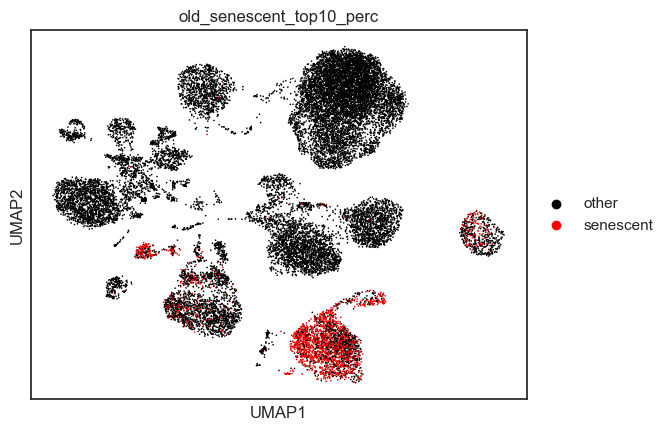

In [25]:
# plot umap with senescent cells marked in red
sns.set_style("white")
custom_palette = {'other': 'black', 'senescent': 'red'}
sc.pl.umap(old_subset, color='old_senescent_top10_perc', palette=custom_palette, save = '_sen_vs_other.png')

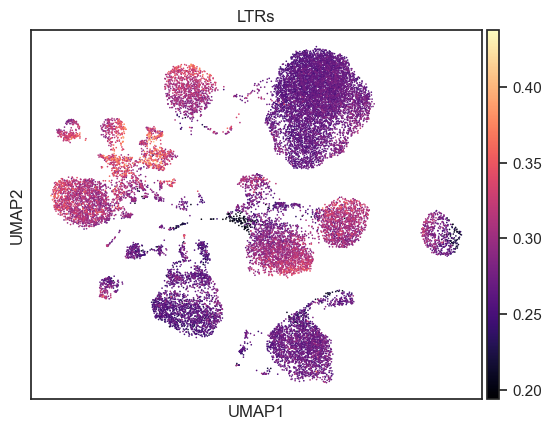

In [123]:
# plot LTR UCell scores as a gradient
sc.pl.umap(old_subset, color = 'LTRs', cmap = 'magma', save  = 'LTR_UCell.png')

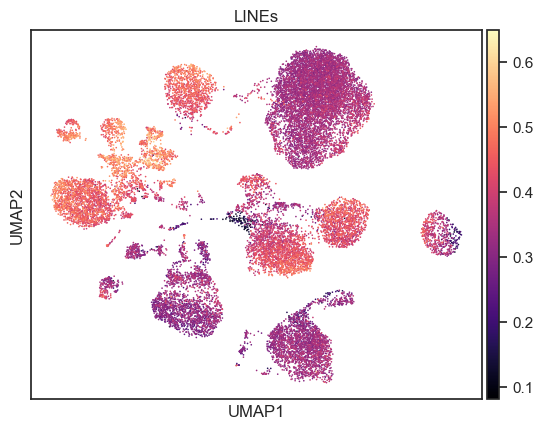

In [124]:
# plot LINE UCell scores as a gradient
sc.pl.umap(old_subset, color = 'LINEs', cmap = 'magma',save = 'LINE_UCell.png')

In [227]:
# write to senescent cell counts for each cell type to a file
data_frame_for_article = df_type_counts
data_frame_for_article.to_csv('data/processed/old_senescent_cells_types.csv')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

senescent v.s. other: t-test independent samples with Bonferroni correction, P_val=1.337e-170 stat=-2.810e+01


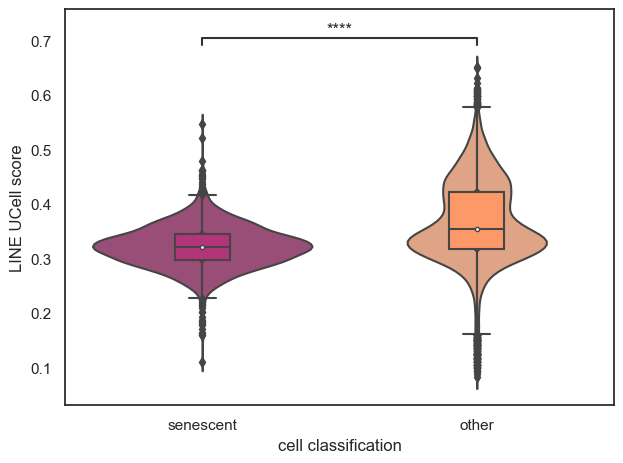

In [238]:
# plot the distribution of LINE UCell scores for the cell population marked as senescent and all other cells separately

df_sen = old_subset.obs[old_subset.obs['old_senescent_top10_perc'] == 'senescent']
df_other = old_subset.obs[old_subset.obs['old_senescent_top10_perc'] == 'other']

# Combine 'old' and 'young' DataFrames
combined_df = pd.concat([df_other, df_sen])
combined_df['old_senescent_top10_perc'] = pd.Categorical(combined_df['old_senescent_top10_perc'], categories=['senescent', 'other'])
#combined_df['sen'] = pd.Categorical(combined_df['condition'], categories=['young', 'old'])

# Create the violin plot using seaborn
ax = sns.violinplot(data=combined_df, x='old_senescent_top10_perc', y='LINEs', palette={'other':plt.cm.magma(200), 'senescent':plt.cm.magma(125)}, saturation = 0.6)

sns.boxplot(x='old_senescent_top10_perc', y='LINEs', data=combined_df, palette={'other':plt.cm.magma(200), 'senescent':plt.cm.magma(125)}, saturation = 1, width=0.2,
            boxprops={'zorder': 2}, ax=ax)

# Add statistical significance annotation
add_stat_annotation(ax, data=combined_df,
                    x='old_senescent_top10_perc',
                    y='LINEs',
                    test='t-test_ind',
                    comparisons_correction='bonferroni',
                    box_pairs=[('other', 'senescent')])

# Set the x-axis label
plt.xlabel('cell classification')

# Set the y-axis label
plt.ylabel('LINE UCell score')

# Save the figure
plt.tight_layout()
plt.savefig('figures/report/UCell/violin_old_senescent_LINE_UCell.png', dpi=300)

# Show the plot
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

senescent v.s. other: t-test independent samples with Bonferroni correction, P_val=1.421e-103 stat=-2.173e+01


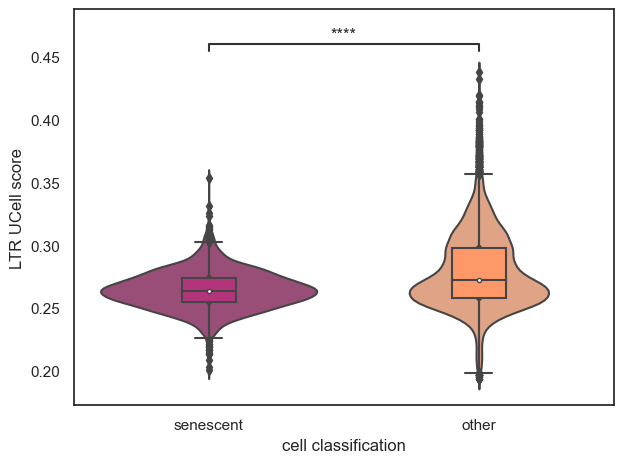

In [239]:
# plot the distribution of LTR UCell scores for the cell population marked as senescent and all other cells separately

df_sen = old_subset.obs[old_subset.obs['old_senescent_top10_perc'] == 'senescent']
df_other = old_subset.obs[old_subset.obs['old_senescent_top10_perc'] == 'other']

# Combine 'old' and 'young' DataFrames
combined_df = pd.concat([df_sen, df_other])
combined_df['old_senescent_top10_perc'] = pd.Categorical(combined_df['old_senescent_top10_perc'], categories=['senescent', 'other'])

# Create the violin plot using seaborn
ax = sns.violinplot(data=combined_df, x='old_senescent_top10_perc', y='LTRs', palette={'other':plt.cm.magma(200), 'senescent':plt.cm.magma(125)}, saturation = 0.6)

sns.boxplot(x='old_senescent_top10_perc', y='LTRs', data=combined_df, palette={'other':plt.cm.magma(200), 'senescent':plt.cm.magma(125)}, saturation = 1, width=0.2,
            boxprops={'zorder': 2}, ax=ax)

# Add statistical significance annotation
add_stat_annotation(ax, data=combined_df,
                    x='old_senescent_top10_perc',
                    y='LTRs',
                    test='t-test_ind',
                    comparisons_correction='bonferroni',
                    box_pairs=[('other', 'senescent')])

# Set the x-axis label
plt.xlabel('cell classification')

# Set the y-axis label
plt.ylabel('LTR UCell score')

# Save the figure
plt.tight_layout()
plt.savefig('figures/report/UCell/violin_old_senescent_LTR_UCell.png', dpi=300)

# Show the plot
plt.show()

In [ ]:
# From here onwards, correlation plots are created. 
# For each cell type individually, all cells of the aged samples are subsetted to only that
# cell type. Subsetquently, cells having a SenMayo score of 0 for SenMayo are removed. Subsequently,
# the meta data for all left cells is saved in an object. Subsequently, correlation plots for
# LINE and LTR UCell scores against SenMayo UCell scores are created.

In [85]:
# microglia and macrophages
subset_mm = old_subset[old_subset.obs['cell_type'] == 'microglia & macrophages'].copy()
meta_mm = subset_mm.obs
meta_mm = meta_mm[meta_mm['SenMayo'] > 0]
meta_mm

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,X_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc
X,,,,,,,,,,,,,,,,,,,,
old_AAAGTAGGTTTAAGCC.1,OX1X,old,True,3014,1356,1356,3014,130,4.313205,0,0,3,microglia & macrophages,0.377089,0.398832,0.275041,0.093336,other,0,other
old_AAATGCCCAAGGACTG.1,OX1X,old,True,1339,625,625,1339,112,8.364450,0,0,3,microglia & macrophages,0.093282,0.328605,0.276731,0.080658,other,0,other
old_AACCATGTCCCTTGCA.1,OX1X,old,True,4064,1538,1538,4064,157,3.863189,0,0,3,microglia & macrophages,0.452396,0.354879,0.279514,0.101938,senescent,1,senescent
old_AACCGCGAGCTAGTCT.1,OX1X,old,True,6702,1715,1715,6702,199,2.969263,0,0,3,microglia & macrophages,0.227063,0.315137,0.268421,0.114483,senescent,1,senescent
old_AACCGCGCAAAGGCGT.1,OX1X,old,True,4054,1553,1553,4054,126,3.108041,0,0,3,microglia & macrophages,0.416456,0.346329,0.265494,0.079850,other,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
old_TTTATGCGTTATCGGT.1,OX8X,old,True,1269,770,770,1269,33,2.600473,0,0,3,microglia & macrophages,0.388830,0.285614,0.266516,0.099531,senescent,1,senescent
old_TTTCCTCTCTCATTCA.1,OX8X,old,True,1127,658,658,1127,35,3.105590,0,0,3,microglia & macrophages,0.439712,0.345446,0.276355,0.091881,other,0,other
old_TTTGCGCAGTGTCCAT.1,OX8X,old,True,1155,705,705,1155,36,3.116883,0,0,3,microglia & macrophages,0.320873,0.309956,0.261014,0.091653,other,0,other


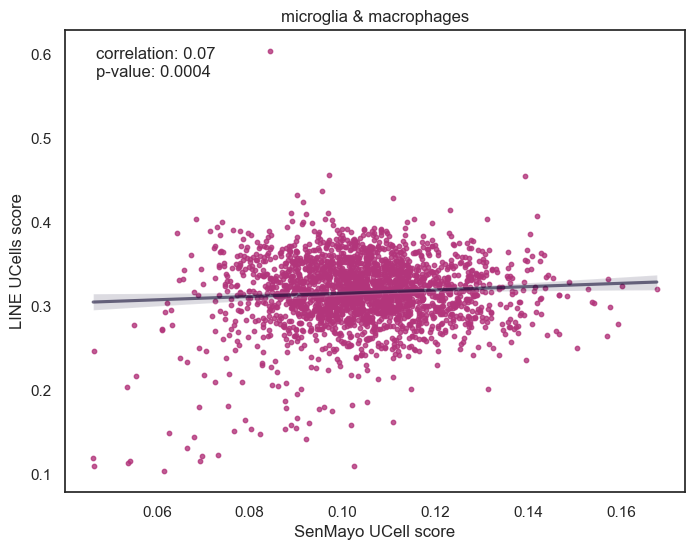

In [86]:
# plot LINEs vs SenMayo
from scipy.stats import pearsonr
plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LINEs", data=meta_mm2, scatter_kws={"s": 10, "color": plt.cm.magma(125)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_mm2["SenMayo"], meta_mm2["LINEs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LINE UCells score")
plt.title("microglia & macrophages")

plt.savefig('figures/report/UCell/cor_mm_old_sen_LINE_UCell.png', dpi=300)


plt.show()

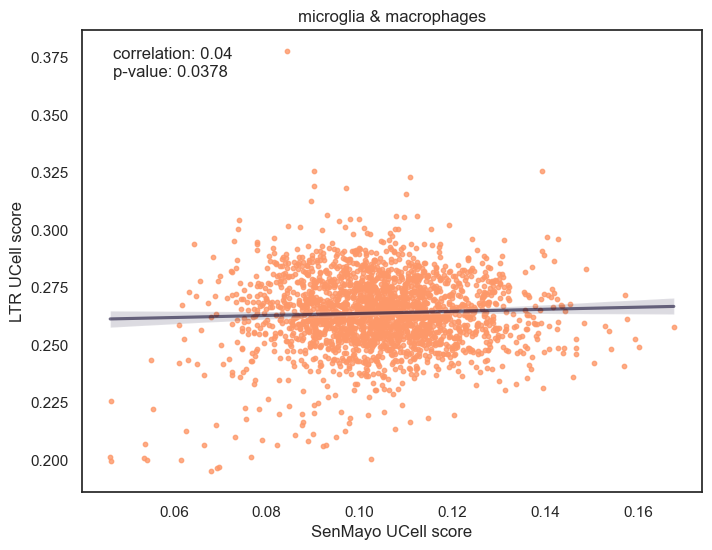

In [87]:
# plot LTRs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LTRs", data=meta_mm2, scatter_kws={"s": 10, "color": plt.cm.magma(200)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_mm2["SenMayo"], meta_mm2["LTRs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LTR UCell score")
plt.title("microglia & macrophages")

plt.savefig('figures/report/UCell/cor_mm_old_sen_LTR_UCell.png', dpi=300)

plt.show()

In [88]:
# endothelial and vascular cells

subset_ev = old_subset[old_subset.obs['cell_type'] == 'endothelial & vascular cells'].copy()
meta_ev = subset_ev.obs
meta_ev = meta_ev[meta_ev['SenMayo'] > 0]
meta_ev

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,X_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc
X,,,,,,,,,,,,,,,,,,,,
old_AAACGGGAGCGATGAC.1,OX1X,old,True,5115,2015,2015,5115,219,4.281525,0,0,4,endothelial & vascular cells,0.229350,0.312759,0.259830,0.094836,other,0,other
old_AAAGATGAGATGTAAC.1,OX1X,old,True,3359,1559,1559,3359,115,3.423638,0,0,4,endothelial & vascular cells,0.175251,0.329082,0.256350,0.099573,senescent,1,senescent
old_AAATGCCAGGCAATTA.1,OX1X,old,True,3471,1677,1677,3471,253,7.288966,0,0,4,endothelial & vascular cells,0.216652,0.359987,0.273471,0.084489,other,0,other
old_AAATGCCCACAGAGGT.1,OX1X,old,True,1781,954,954,1781,299,16.788322,0,0,4,endothelial & vascular cells,0.226656,0.301082,0.256273,0.072571,other,0,other
old_AACACGTTCTCGGACG.1,OX1X,old,True,5884,2474,2474,5884,333,5.659415,0,0,4,endothelial & vascular cells,0.166868,0.347691,0.269347,0.096958,other,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
old_TTTCCTCAGACAATAC.1,OX8X,old,True,1250,781,781,1250,77,6.160000,0,0,4,endothelial & vascular cells,0.223973,0.265552,0.243346,0.072667,other,0,other
old_TTTGCGCCAGCGAACA.1,OX8X,old,True,1994,1086,1086,1994,108,5.416249,0,0,4,endothelial & vascular cells,0.176945,0.268082,0.253307,0.072339,other,0,other
old_TTTGCGCGTGCGCTTG.1,OX8X,old,True,4257,1992,1992,4257,221,5.191450,0,0,4,endothelial & vascular cells,0.305748,0.294320,0.257762,0.100958,senescent,1,senescent


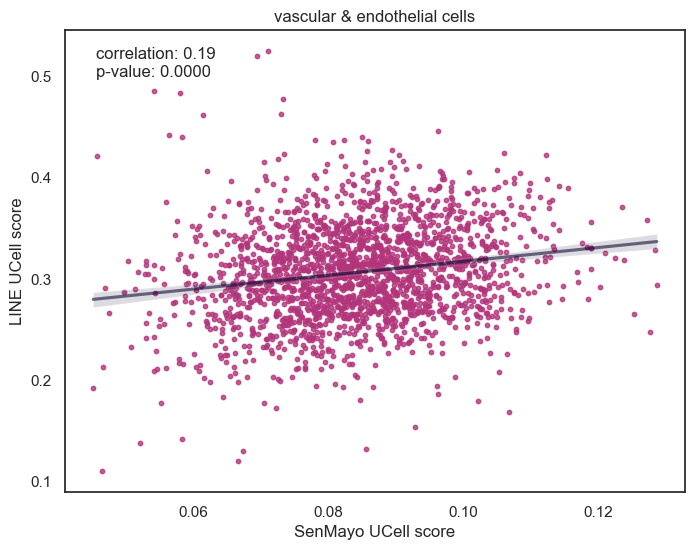

In [89]:
# plot LINEs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LINEs", data=meta_ev2, scatter_kws={"s": 10, "color": plt.cm.magma(125)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_ev2["SenMayo"], meta_ev2["LINEs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LINE UCell score")
plt.title("vascular & endothelial cells")

plt.savefig('figures/report/UCell/cor_ve_old_sen_LINE_UCell.png', dpi=300)

plt.show()

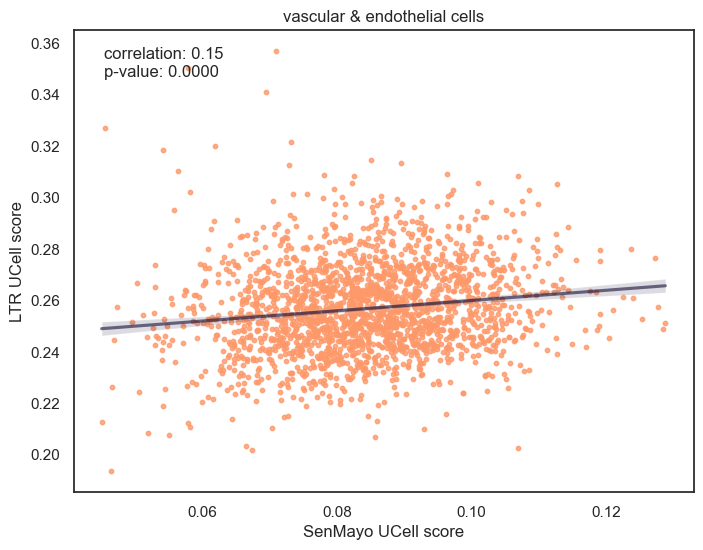

In [90]:
# plot LTRs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LTRs", data=meta_ev2, scatter_kws={"s": 10, "color": plt.cm.magma(200)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_ev2["SenMayo"], meta_ev2["LTRs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LTR UCell score")
plt.title("vascular & endothelial cells")

plt.savefig('figures/report/UCell/cor_ve_old_sen_LTR_UCell.png', dpi=300)

plt.show()

In [91]:
# arachnoid barrier and choroid plexus cells

subset_ac = old_subset[old_subset.obs['cell_type'] == 'arachnoid barrier & choroid plexus cells'].copy()
meta_ac = subset_ac.obs
meta_ac = meta_ac[meta_ac['SenMayo'] > 0]
meta_ac

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,X_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc
X,,,,,,,,,,,,,,,,,,,,
old_AAACCTGGTTCTCATT.1,OX1X,old,True,3784,1569,1569,3784,194,5.126850,0,0,10,arachnoid barrier & choroid plexus cells,0.076720,0.357415,0.270314,0.103331,senescent,1,senescent
old_AAATGCCAGGGTCGAT.1,OX1X,old,True,4849,1448,1448,4849,78,1.608579,0,0,10,arachnoid barrier & choroid plexus cells,0.038281,0.287563,0.241026,0.066328,other,0,other
old_AGTTGGTCAAACGCGA.1,OX1X,old,True,8342,1736,1736,8342,922,11.052506,0,0,10,arachnoid barrier & choroid plexus cells,0.040153,0.313060,0.255695,0.087655,other,0,other
old_CACCACTAGTTCGATC.1,OX1X,old,True,5537,1952,1952,5537,245,4.424779,0,0,10,arachnoid barrier & choroid plexus cells,0.081611,0.333020,0.254552,0.138347,senescent,1,senescent
old_CACCACTGTCTTGCGG.1,OX1X,old,True,9608,2938,2938,9608,586,6.099084,0,0,10,arachnoid barrier & choroid plexus cells,0.077192,0.308490,0.260220,0.083593,other,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
old_TCGTACCCAGTATCTG.1-1,OX8X,old,True,4424,979,979,4424,371,8.386076,0,0,10,arachnoid barrier & choroid plexus cells,0.042240,0.223230,0.238007,0.082508,other,0,other
old_TCTGAGATCATCGGAT.1-1,OX8X,old,True,4653,1812,1812,4653,381,8.188266,0,0,10,arachnoid barrier & choroid plexus cells,0.082288,0.287245,0.239699,0.098136,other,0,other
old_TCTTCGGCACGCGAAA.1,OX8X,old,True,3439,1535,1535,3439,216,6.280895,0,0,10,arachnoid barrier & choroid plexus cells,0.080016,0.318026,0.265399,0.108294,senescent,1,senescent


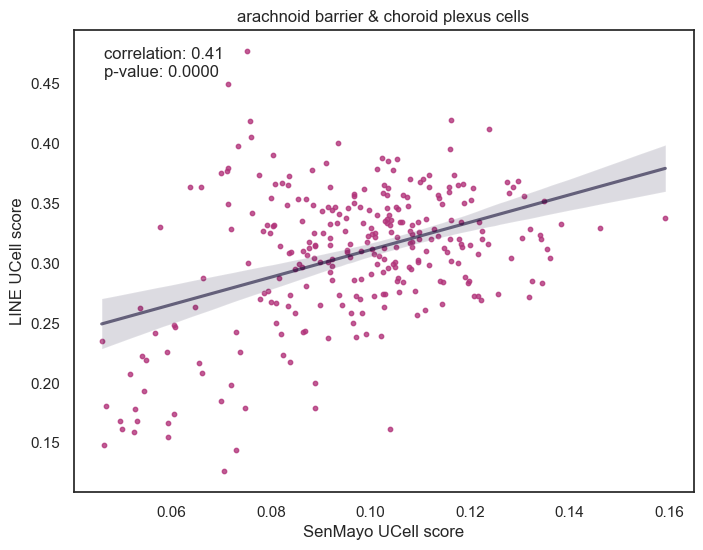

In [92]:
# plot LINEs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LINEs", data=meta_ac, scatter_kws={"s": 10, "color": plt.cm.magma(125)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_ac["SenMayo"], meta_ac["LINEs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LINE UCell score")
plt.title("arachnoid barrier & choroid plexus cells")

plt.savefig('figures/report/UCell/cor_ac_old_sen_LINE_UCell.png', dpi=300)

plt.show()

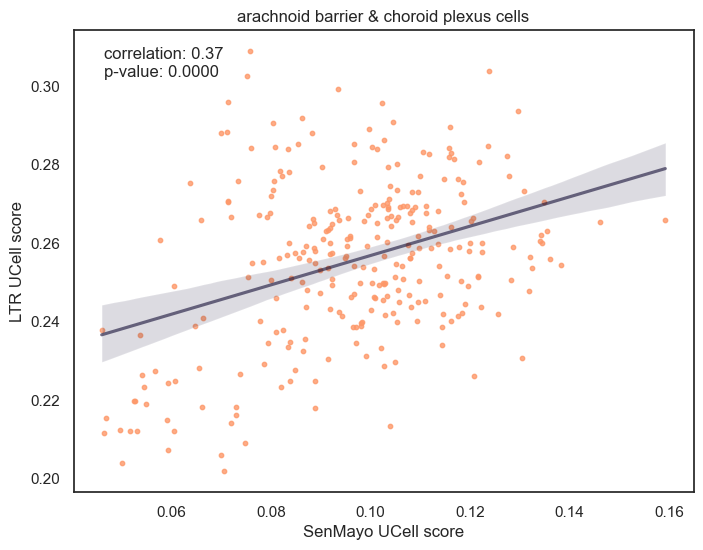

In [93]:
# plot LTRs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LTRs", data=meta_ac, scatter_kws={"s": 10, "color": plt.cm.magma(200)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_ac["SenMayo"], meta_ac["LTRs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LTR UCell score")
plt.title("arachnoid barrier & choroid plexus cells")

plt.savefig('figures/report/UCell/cor_ac_old_sen_LTR_UCell.png', dpi=300)

plt.show()

In [94]:
# olfactory ensheathing glia

subset_oeg = old_subset[old_subset.obs['cell_type'] == 'olfactory ensheathing glia'].copy()
meta_oeg = subset_oeg.obs
meta_oeg = meta_oeg[meta_oeg['SenMayo'] > 0]
meta_oeg

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,X_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc
X,,,,,,,,,,,,,,,,,,,,
old_AACCGCGAGTTCCACA.1,OX1X,old,True,5773,2124,2124,5773,494,8.557076,0,0,7,olfactory ensheathing glia,0.120749,0.341327,0.254904,0.091144,other,0,other
old_AACTTTCGTTGCGTTA.1,OX1X,old,True,4836,1855,1855,4836,338,6.989247,0,0,7,olfactory ensheathing glia,0.095147,0.343351,0.266908,0.095421,other,0,other
old_ACACCAATCTTCAACT.1,OX1X,old,True,4330,1778,1778,4330,455,10.508082,0,0,7,olfactory ensheathing glia,0.124654,0.387766,0.291191,0.102234,senescent,1,senescent
old_ACGCAGCAGTGGTAGC.1,OX1X,old,True,4383,1855,1855,4383,234,5.338809,0,0,7,olfactory ensheathing glia,0.120409,0.348927,0.269959,0.101240,senescent,1,senescent
old_AGAGTGGGTTCAGTAC.1,OX1X,old,True,1978,1087,1087,1978,62,3.134479,0,0,7,olfactory ensheathing glia,0.079629,0.347523,0.288587,0.092161,other,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
old_TGACAACAGTACCGGA.1,OX8X,old,True,3831,1631,1631,3831,210,5.481597,0,0,7,olfactory ensheathing glia,0.117125,0.379232,0.252657,0.091356,other,0,other
old_TGACTAGCATGTAAGA.1,OX8X,old,True,3056,1407,1407,3056,161,5.268324,0,0,7,olfactory ensheathing glia,0.133965,0.359768,0.288700,0.122811,senescent,1,senescent
old_TGTCCCATCTTCGGTC.1,OX8X,old,True,3020,1146,1146,3020,151,5.000000,0,0,7,olfactory ensheathing glia,0.141788,0.392419,0.282441,0.109017,senescent,1,senescent


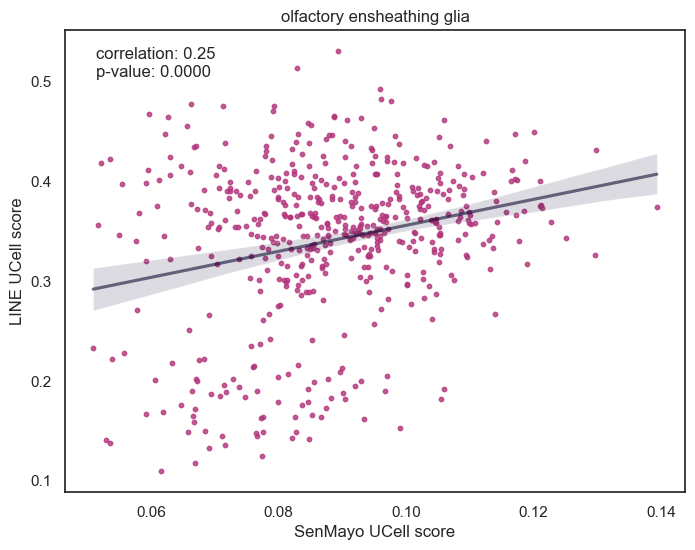

In [95]:
# plot LINEs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LINEs", data=meta_oeg, scatter_kws={"s": 10, "color": plt.cm.magma(125)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_oeg["SenMayo"], meta_oeg["LINEs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LINE UCell score")
plt.title("olfactory ensheathing glia")

plt.savefig('figures/report/UCell/cor_oeg_old_sen_LINE_UCell.png', dpi=300)

plt.show()

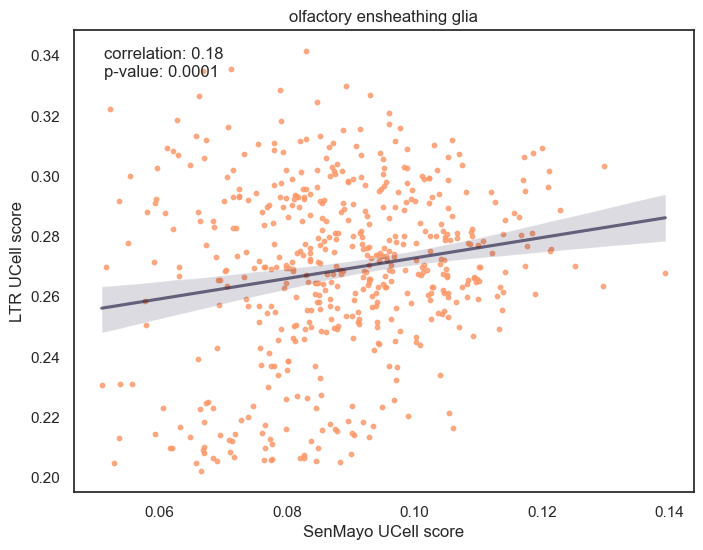

In [96]:
# plot LTRs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LTRs", data=meta_oeg, scatter_kws={"s": 10, "color": plt.cm.magma(200)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_oeg["SenMayo"], meta_oeg["LTRs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LTR UCell score")
plt.title("olfactory ensheathing glia")

plt.savefig('figures/report/UCell/cor_oeg_old_sen_LTR_UCell.png', dpi=300)

plt.show()

In [97]:
# neurons

subset_neu = old_subset[old_subset.obs['cell_type'] == 'neurons'].copy()
meta_neu = subset_neu.obs
meta_neu = meta_neu[meta_neu['SenMayo'] > 0]
meta_neu

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,X_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc
X,,,,,,,,,,,,,,,,,,,,
old_AAAGCAATCCCAGGTG.1,OX1X,old,True,1128,703,703,1128,155,13.741134,0,0,11,neurons,0.061590,0.437711,0.304936,0.059150,other,0,other
old_AAATGCCGTCAGTGGA.1,OX1X,old,True,3856,2025,2025,3856,186,4.823651,0,0,2,neurons,0.359712,0.476227,0.305242,0.056415,other,0,other
old_AAATGCCTCGGTTAAC.1,OX1X,old,True,2055,1184,1184,2055,171,8.321168,0,0,2,neurons,0.295573,0.458525,0.324230,0.047734,other,0,other
old_AACGTTGCATGCGCAC.1,OX1X,old,True,2260,1229,1229,2260,116,5.132743,0,0,2,neurons,0.424517,0.425146,0.290194,0.046017,other,0,other
old_AACTCTTAGCTTATCG.1,OX1X,old,True,2219,1285,1285,2219,183,8.246958,0,0,2,neurons,0.341787,0.453521,0.307196,0.053853,other,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
old_TTTCCTCAGCTGAAAT.1,OX8X,old,True,1084,665,665,1084,100,9.225092,0,0,2,neurons,0.342676,0.475424,0.337670,0.045251,other,0,other
old_TTTCCTCTCGGTGTCG.1,OX8X,old,True,1777,1076,1076,1777,116,6.527856,0,0,2,neurons,0.279811,0.396132,0.306358,0.048475,other,0,other
old_TTTGCGCCATGCAACT.1,OX8X,old,True,1956,1134,1134,1956,145,7.413088,0,0,2,neurons,0.343671,0.417095,0.308565,0.055130,other,0,other


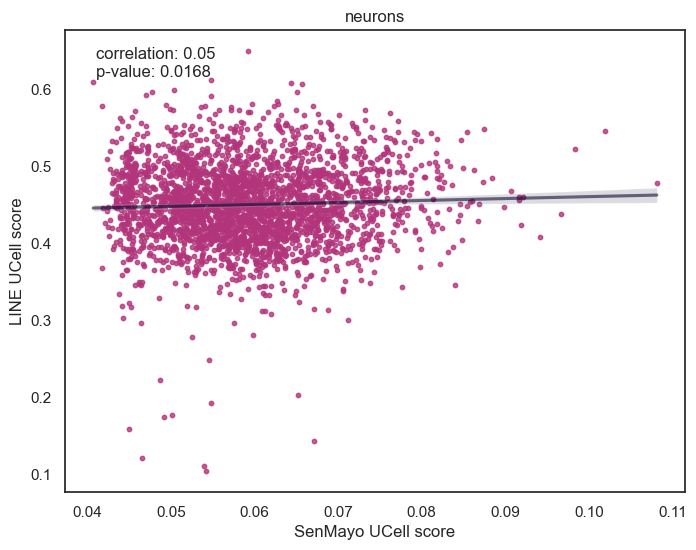

In [98]:
# plot LINEs vs SenMayo

plt.figure(figsize=(8, 6))
from scipy.stats import pearsonr

sns.regplot(x="SenMayo", y="LINEs", data=meta_neu2, scatter_kws={"s": 10, "color": plt.cm.magma(125)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_neu2["SenMayo"], meta_neu2["LINEs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LINE UCell score")
plt.title("neurons")

plt.savefig('figures/report/UCell/cor_neu_old_sen_LINE_UCell.png', dpi=300)

plt.show()

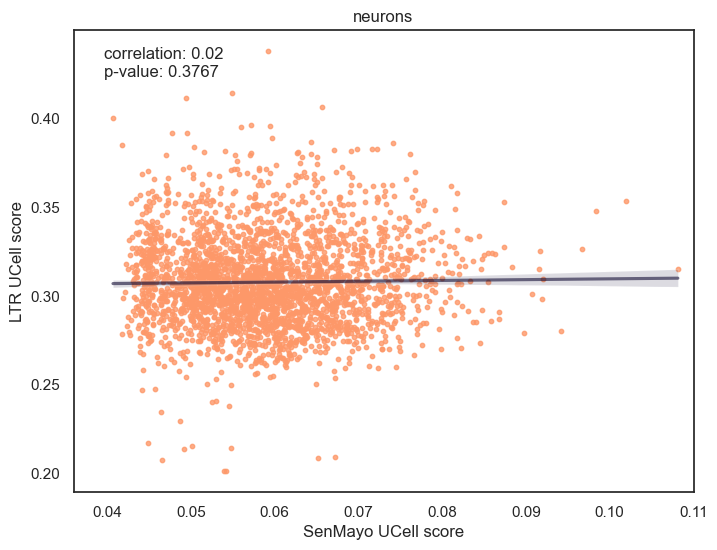

In [99]:
# plot LTRs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LTRs", data=meta_neu2, scatter_kws={"s": 10, "color": plt.cm.magma(200)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_neu2["SenMayo"], meta_neu2["LTRs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)
plt.xlim(0.036, 0.11)


# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LTR UCell score")
plt.title("neurons")

plt.savefig('figures/report/UCell/cor_neu_old_sen_LTR_UCell.png', dpi=300)

plt.show()

In [101]:
# astrocytes

subset_ast = old_subset[old_subset.obs['cell_type'] == 'astrocytes'].copy()
meta_ast = subset_ast.obs
meta_ast = meta_ast[meta_ast['SenMayo'] > 0]
meta_ast

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,X_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc
X,,,,,,,,,,,,,,,,,,,,
old_AAACGGGTCAAGGCTT.1,OX1X,old,True,2711,1375,1375,2711,399,14.717815,0,0,5,astrocytes,0.291825,0.354488,0.283529,0.072223,other,0,other
old_AAAGATGGTAATAGCA.1,OX1X,old,True,1913,1109,1109,1913,104,5.436487,0,0,1,astrocytes,0.429107,0.423234,0.302189,0.068065,other,0,other
old_AAAGCAAGTTTACTCT.1,OX1X,old,True,2671,1454,1454,2671,177,6.626732,0,0,5,astrocytes,0.331026,0.373159,0.298374,0.065966,other,0,other
old_AAATGCCCATATACCG.1,OX1X,old,True,1062,637,637,1062,94,8.851224,0,0,5,astrocytes,0.343781,0.404766,0.302454,0.072322,other,0,other
old_AACACGTAGACACGAC.1,OX1X,old,True,2634,1365,1365,2634,115,4.365983,0,0,1,astrocytes,0.422644,0.449307,0.304593,0.057780,other,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
old_TTTGCGCCAGGGTATG.1,OX8X,old,True,1414,764,764,1414,118,8.345120,0,0,5,astrocytes,0.337161,0.391380,0.287907,0.067169,other,0,other
old_TTTGCGCCATCCAACA.1,OX8X,old,True,1344,740,740,1344,82,6.101190,0,0,5,astrocytes,0.270987,0.396589,0.321219,0.085280,other,0,other
old_TTTGCGCGTATATCCG.1,OX8X,old,True,4565,1921,1921,4565,421,9.222343,0,0,1,astrocytes,0.157109,0.304362,0.254299,0.081054,other,0,other


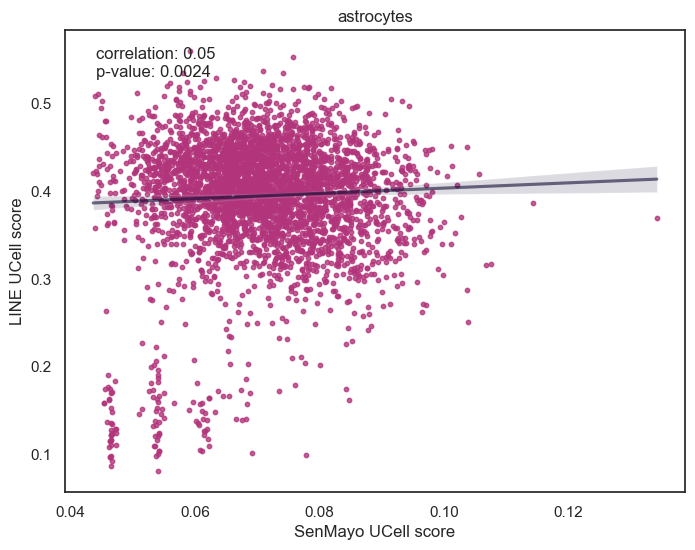

In [103]:
# plot LINEs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LINEs", data=meta_ast2, scatter_kws={"s": 10, "color": plt.cm.magma(125)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_ast2["SenMayo"], meta_ast2["LINEs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LINE UCell score")
plt.title("astrocytes")

plt.savefig('figures/report/UCell/cor_ast_old_sen_LINE_UCell.png', dpi=300)

plt.show()

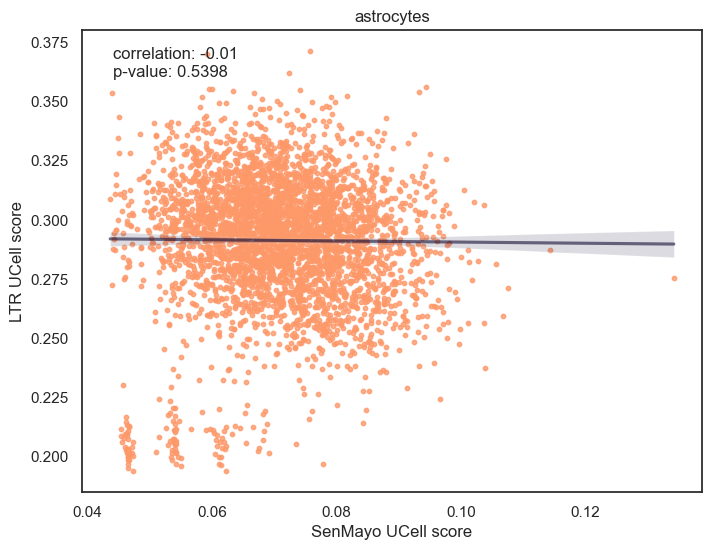

In [104]:
# plot LTRs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LTRs", data=meta_ast2, scatter_kws={"s": 10, "color": plt.cm.magma(200)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_ast2["SenMayo"], meta_ast2["LTRs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LTR UCell score")
plt.title("astrocytes")

plt.savefig('figures/report/UCell/cor_ast_old_sen_LTR_UCell.png', dpi=300)

plt.show()

In [106]:
# oligodendrocytes

subset_oli = old_subset[old_subset.obs['cell_type'] == 'oligodendrocytes'].copy()
meta_oli = subset_oli.obs
meta_oli = meta_oli[meta_oli['SenMayo'] > 0]
meta_oli

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,X_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc
X,,,,,,,,,,,,,,,,,,,,
old_AAACGGGTCCGTAGTA.1,OX1X,old,True,3738,1665,1665,3738,203,5.430711,0,0,0,oligodendrocytes,0.879616,0.312971,0.261709,0.060065,other,0,other
old_AAAGATGAGAATTCCC.1,OX1X,old,True,3869,1671,1671,3869,179,4.626518,0,0,0,oligodendrocytes,0.602854,0.358837,0.273210,0.073907,other,0,other
old_AAAGCAAAGAGGACGG.1,OX1X,old,True,2697,1326,1326,2697,167,6.192065,0,0,0,oligodendrocytes,0.701564,0.318678,0.265734,0.068831,other,0,other
old_AAAGCAACAACACCCG.1,OX1X,old,True,3955,1767,1767,3955,197,4.981037,0,0,0,oligodendrocytes,0.926804,0.331660,0.272284,0.067627,other,0,other
old_AAAGTAGGTAGAAAGG.1,OX1X,old,True,3831,1609,1609,3831,391,10.206213,0,0,0,oligodendrocytes,0.413580,0.368488,0.278394,0.051045,other,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
old_TTTGGTTAGCGTCAAG.1-1,OX8X,old,True,2010,977,977,2010,154,7.661691,0,0,0,oligodendrocytes,0.905699,0.311881,0.254712,0.075638,other,0,other
old_TTTGGTTAGTATTGGA.1,OX8X,old,True,10218,3243,3243,10218,321,3.141515,0,0,0,oligodendrocytes,0.187605,0.373691,0.276657,0.060158,other,0,other
old_TTTGTCAAGTTATCGC.1,OX8X,old,True,1087,492,492,1087,199,18.307266,0,0,0,oligodendrocytes,0.171234,0.351751,0.258536,0.055398,other,0,other


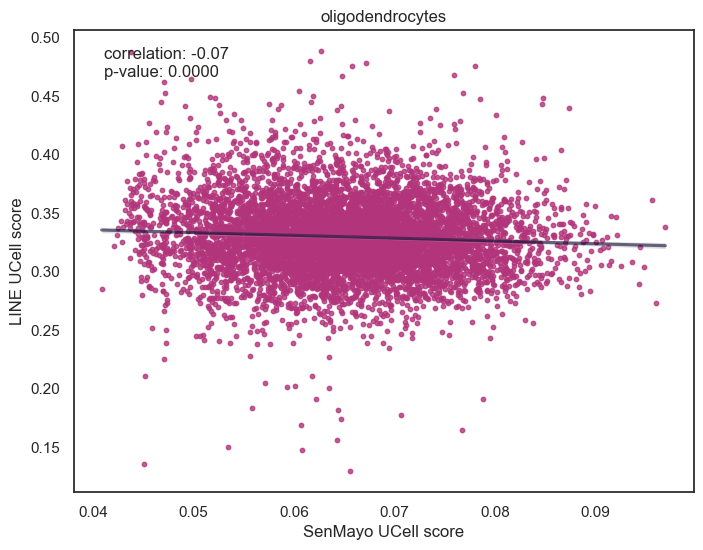

In [107]:
# plot LINEs vs SenMayo

sns.set_style("white")
plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LINEs", data=meta_oli2, scatter_kws={"s": 10, "color": plt.cm.magma(125)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_oli2["SenMayo"], meta_oli2["LINEs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LINE UCell score")
plt.title("oligodendrocytes")

plt.savefig('figures/report/UCell/cor_oli_old_sen_LINE_UCell.png', dpi=300)

plt.show()

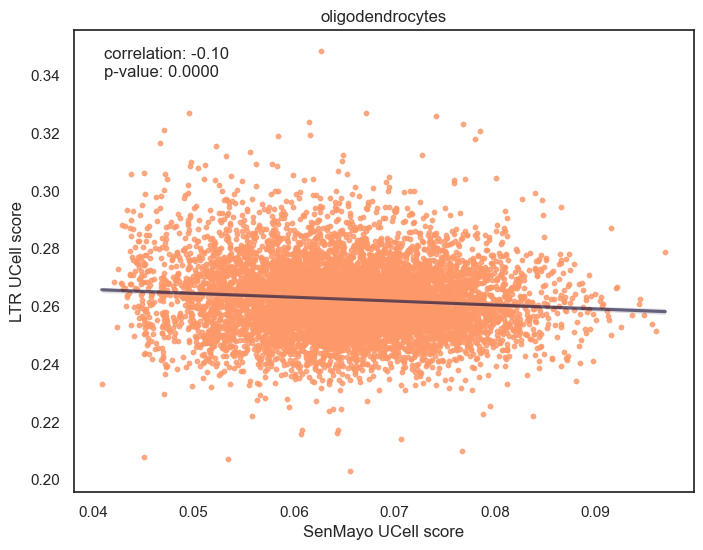

In [108]:
# plot LTRs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LTRs", data=meta_oli2, scatter_kws={"s": 10, "color": plt.cm.magma(200)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_oli2["SenMayo"], meta_oli2["LTRs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LTR UCell score")
plt.title("oligodendrocytes")

plt.savefig('figures/report/UCell/cor_oli_old_sen_LTR_UCell.png', dpi=300)

plt.show()

In [109]:
# oligodendrocyte precursors

subset_oep = old_subset[old_subset.obs['cell_type'] == 'oligodendrocyte precursors'].copy()
meta_oep = subset_oep.obs
meta_oep = meta_oep[meta_oep['SenMayo'] > 0]
meta_oep

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,X_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc
X,,,,,,,,,,,,,,,,,,,,
old_AACTCCCGTATATGAG.1,OX1X,old,True,2480,1509,1509,2480,146,5.887097,0,0,6,oligodendrocyte precursors,0.176908,0.472812,0.304494,0.064814,other,0,other
old_AACTCTTAGGGTTTCT.1,OX1X,old,True,2095,1304,1304,2095,177,8.448688,0,0,6,oligodendrocyte precursors,0.129726,0.539828,0.364921,0.078619,other,0,other
old_AAGGTTCAGAGAACAG.1,OX1X,old,True,2150,1343,1343,2150,162,7.534884,0,0,6,oligodendrocyte precursors,0.115358,0.469000,0.330391,0.069624,other,0,other
old_ACACCCTGTTCACCTC.1,OX1X,old,True,2159,1248,1248,2159,86,3.983325,0,0,6,oligodendrocyte precursors,0.201183,0.427775,0.298550,0.076260,other,0,other
old_ACATACGGTCATACTG.1,OX1X,old,True,3129,1722,1722,3129,219,6.999041,0,0,6,oligodendrocyte precursors,0.134432,0.459775,0.325878,0.071881,other,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
old_TTGGCAATCGTGACAT.1,OX8X,old,True,1545,1030,1030,1545,98,6.343042,0,0,6,oligodendrocyte precursors,0.214998,0.411932,0.279147,0.091723,other,0,other
old_TTTACTGAGAAACGAG.1,OX8X,old,True,2881,1684,1684,2881,138,4.790004,0,0,6,oligodendrocyte precursors,0.209502,0.393022,0.283302,0.076483,other,0,other
old_TTTACTGGTCTCTTTA.1,OX8X,old,True,2370,1406,1406,2370,124,5.232068,0,0,6,oligodendrocyte precursors,0.251870,0.446439,0.294388,0.079605,other,0,other


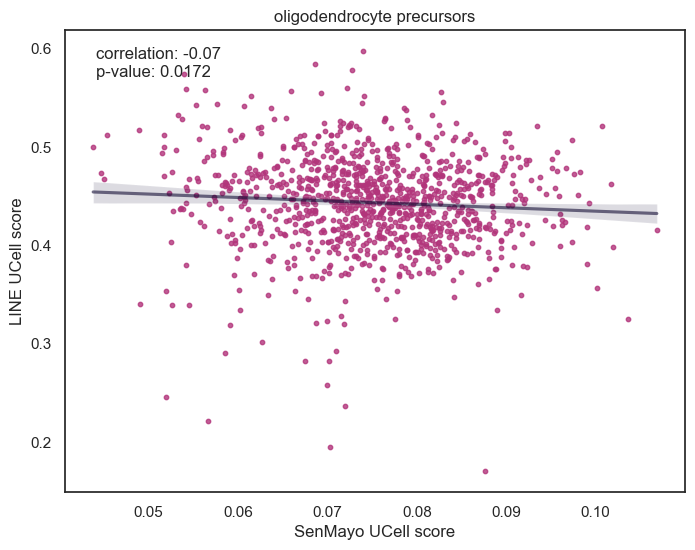

In [110]:
# plot LINEs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LINEs", data=meta_oep, scatter_kws={"s": 10, "color": plt.cm.magma(125)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_oep["SenMayo"], meta_oep["LINEs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LINE UCell score")
plt.title("oligodendrocyte precursors")

plt.savefig('figures/report/UCell/cor_oep_old_sen_LINE_UCell.png', dpi=300)

plt.show()

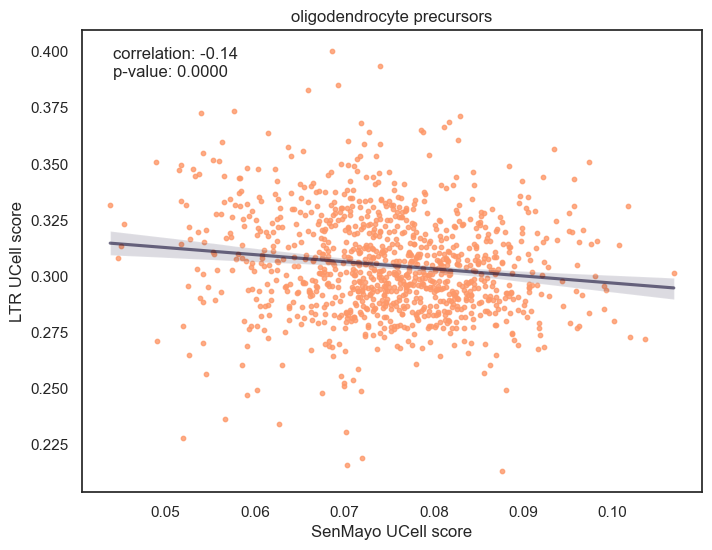

In [111]:
# plot LTRs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LTRs", data=meta_oep, scatter_kws={"s": 10, "color": plt.cm.magma(200)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_oep["SenMayo"], meta_oep["LTRs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LTR UCell score")
plt.title("oligodendrocyte precursors")

plt.savefig('figures/report/UCell/cor_oep_old_sen_LTR_UCell.png', dpi=300)

plt.show()

In [112]:
subset_blo = old_subset[old_subset.obs['cell_type'] == 'monocytes, neutrophils & dendritic cells'].copy()
meta_blo = subset_blo.obs
meta_blo = meta_blo[meta_blo['SenMayo'] > 0]
meta_blo

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,X_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc
X,,,,,,,,,,,,,,,,,,,,
old_AAACCTGTCGGTTCGG.1,OX1X,old,True,3280,1120,1120,3280,98,2.987805,0,0,9,"monocytes, neutrophils & dendritic cells",0.035155,0.284554,0.265461,0.091186,other,0,other
old_AAATGCCAGGCGATAC.1,OX1X,old,True,5678,1722,1722,5678,122,2.148644,0,0,9,"monocytes, neutrophils & dendritic cells",0.033973,0.311746,0.246301,0.089328,other,0,other
old_AAGACCTAGCGAGAAA.1,OX1X,old,True,3548,1114,1114,3548,117,3.297633,0,0,9,"monocytes, neutrophils & dendritic cells",0.041180,0.306762,0.275091,0.084814,other,0,other
old_ACATACGTCTCGATGA.1,OX1X,old,True,3095,1140,1140,3095,171,5.525040,0,0,9,"monocytes, neutrophils & dendritic cells",0.067148,0.381291,0.291035,0.117771,senescent,1,senescent
old_AGGGATGAGGTTCCTA.1,OX1X,old,True,2319,849,849,2319,103,4.441570,0,0,9,"monocytes, neutrophils & dendritic cells",0.036637,0.254512,0.242435,0.056534,other,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
old_TCTCTAAGTTAGTGGG.1,OX8X,old,True,1100,694,694,1100,56,5.090909,0,0,9,"monocytes, neutrophils & dendritic cells",0.025929,0.389274,0.286148,0.051136,other,0,other
old_TGAAAGACAGACAAGC.1,OX8X,old,True,1655,808,808,1655,57,3.444109,0,0,9,"monocytes, neutrophils & dendritic cells",0.039174,0.250055,0.245854,0.057251,other,0,other
old_TGAAAGACATCCGGGT.1,OX8X,old,True,1536,718,718,1536,68,4.427083,0,0,9,"monocytes, neutrophils & dendritic cells",0.067215,0.266366,0.257741,0.110514,senescent,1,senescent


In [115]:
# neuroendocrine cells

subset_nen = old_subset[old_subset.obs['cell_type'] == 'Neuroendocrine cells'].copy()
meta_nen = subset_nen.obs
meta_nen = meta_nen[meta_nen['SenMayo'] > 0]
meta_nen

,Sample,condition,filtered,n_counts,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,X_scvi_batch,X_scvi_labels,leiden,cell_type,condition_density,LINEs,LTRs,SenMayo,sen_top10_perc,sen_counter,old_senescent_top10_perc
X,,,,,,,,,,,,,,,,,,,,
old_AAAGTAGGTGGAAAGA.1,OX1X,old,True,4555,2235,2235,4555,791,17.365534,0,0,8,Neuroendocrine cells,0.196438,0.569068,0.375112,0.069435,other,0,other
old_AAAGTAGTCGCGATCG.1,OX1X,old,True,5833,2396,2396,5833,1595,27.344421,0,0,8,Neuroendocrine cells,0.116048,0.551254,0.391257,0.087571,other,0,other
old_ACCTTTACAACGCACC.1,OX1X,old,True,11474,4149,4149,11474,847,7.381907,0,0,8,Neuroendocrine cells,0.170717,0.481503,0.313625,0.080729,other,0,other
old_ACGGGTCTCCGTTGCT.1,OX1X,old,True,2408,1375,1375,2408,359,14.908639,0,0,8,Neuroendocrine cells,0.167268,0.537581,0.362721,0.042760,other,0,other
old_AGCATACAGCAGACTG.1,OX1X,old,True,2548,1471,1471,2548,462,18.131868,0,0,8,Neuroendocrine cells,0.119665,0.543634,0.365885,0.049271,other,0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
old_TTCCCAGGTAAGGGAA.1,OX8X,old,True,2299,1404,1404,2299,171,7.438017,0,0,8,Neuroendocrine cells,0.163333,0.507812,0.319297,0.071548,other,0,other
old_TTCTCCTAGCTAGTTC.1,OX8X,old,True,5491,2447,2447,5491,330,6.009834,0,0,8,Neuroendocrine cells,0.168361,0.567269,0.346824,0.061932,other,0,other
old_TTGCGTCTCTCTAGGA.1,OX8X,old,True,5752,2714,2714,5752,484,8.414464,0,0,8,Neuroendocrine cells,0.171672,0.486837,0.319485,0.058452,other,0,other


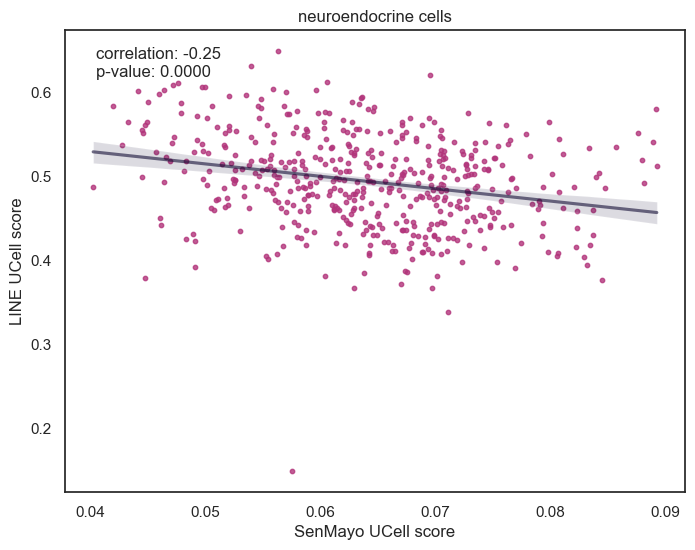

In [116]:
# plot LINEs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LINEs", data=meta_nen, scatter_kws={"s": 10, "color": plt.cm.magma(125)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_nen["SenMayo"], meta_nen["LINEs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LINE UCell score")
plt.title("neuroendocrine cells")

plt.savefig('figures/report/UCell/cor_nen_old_sen_LINE_UCell.png', dpi=300)

plt.show()

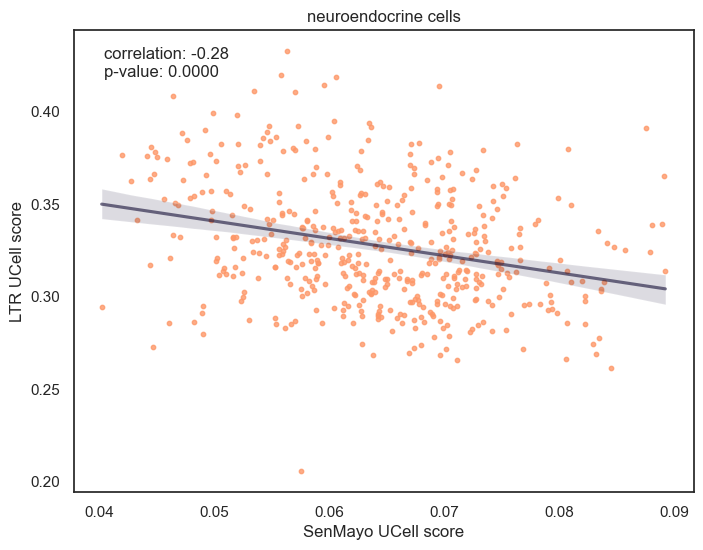

In [117]:
# plot LTRs vs SenMayo

plt.figure(figsize=(8, 6))

sns.regplot(x="SenMayo", y="LTRs", data=meta_nen, scatter_kws={"s": 10, "color": plt.cm.magma(200)}, line_kws={"color": plt.cm.magma(25, alpha=0.6)})

# Calculate correlation and p-value
correlation, p_value = pearsonr(meta_nen["SenMayo"], meta_nen["LTRs"])
significance = f"correlation: {correlation:.2f}\np-value: {p_value:.4f}"
plt.annotate(significance, xy=(0.05, 0.9), xycoords="axes fraction", fontsize=12)

# Set labels and title
plt.xlabel("SenMayo UCell score")
plt.ylabel("LTR UCell score")
plt.title("neuroendocrine cells")

plt.savefig('figures/report/UCell/cor_nen_old_sen_LTR_UCell.png', dpi=300)

plt.show()